In [19]:
#Imports
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs

In [2]:
# Returns equvalent to cdo fldmean
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))

In [3]:
#Define paths
obs_path='obs/'
model_path='input/'
out_path='output/'
eval_path='eval/'
time = '198912-201411'

'''
Define model(s) and the respective variable dicts. (some models dont have the full set of variables available). 
I'd like to write this in a less verbose way, but it seems to involve conversion of string into variable 
via exec() locals() or globals(). I want that even less than long dict def.
'''

obs = { 'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'}

models = {
    'ECE':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'}
}


#Define evaluation models
eval_models = {
    'BCC':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CAMS':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'ECE':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'HadGEM3MM':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'INM5':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'IITM':{
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',},
    'MRI':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'NESM3':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'NOAA-GFDL':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'SNU': {   
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'}
}


#Define regions
regions={'glob' : {
    'lat_min':-90,
    'lat_max':90,},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,},
         
    'southmid' : {
    'lat_min':-90,
    'lat_max':-60,},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,}}

#Define seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']



In [12]:
#Loading obs data
ds_obs = OrderedDict()
for var in obs:
    for seas in seasons:
        print('loading '+obs_path+var+'_'+obs[var]+'_'+seas+'.nc')

        intermediate = xr.open_dataset(obs_path+var+'_'+obs[var]+'_'+seas+'.nc')
        ds_obs[var,seas] = intermediate.compute()

loading obs/siconc_OSISAF_MAM.nc
loading obs/siconc_OSISAF_JJA.nc
loading obs/siconc_OSISAF_SON.nc
loading obs/siconc_OSISAF_DJF.nc
loading obs/tas_ERA5_MAM.nc
loading obs/tas_ERA5_JJA.nc
loading obs/tas_ERA5_SON.nc
loading obs/tas_ERA5_DJF.nc
loading obs/clt_MODIS_MAM.nc
loading obs/clt_MODIS_JJA.nc
loading obs/clt_MODIS_SON.nc
loading obs/clt_MODIS_DJF.nc
loading obs/pr_GPCP_MAM.nc
loading obs/pr_GPCP_JJA.nc
loading obs/pr_GPCP_SON.nc
loading obs/pr_GPCP_DJF.nc
loading obs/rlut_CERES_MAM.nc
loading obs/rlut_CERES_JJA.nc
loading obs/rlut_CERES_SON.nc
loading obs/rlut_CERES_DJF.nc
loading obs/uas_ERA5_MAM.nc
loading obs/uas_ERA5_JJA.nc
loading obs/uas_ERA5_SON.nc
loading obs/uas_ERA5_DJF.nc
loading obs/vas_ERA5_MAM.nc
loading obs/vas_ERA5_JJA.nc
loading obs/vas_ERA5_SON.nc
loading obs/vas_ERA5_DJF.nc
loading obs/ua_ERA5_MAM.nc
loading obs/ua_ERA5_JJA.nc
loading obs/ua_ERA5_SON.nc
loading obs/ua_ERA5_DJF.nc
loading obs/zg_ERA5_MAM.nc
loading obs/zg_ERA5_JJA.nc
loading obs/zg_ERA5_SON.nc

In [13]:
#Loading model data
ds_model = OrderedDict()
for model in models:
    for var in models[model]:
        for seas in seasons:
            print('loading '+model_path+var+'_'+model+'_'+time+'_'+seas+'.nc')
            intermediate = xr.open_dataset(model_path+var+'_'+model+'_'+time+'_'+seas+'.nc')
            ds_model[var,seas,model] = intermediate.compute()

loading input/siconc_ECE_198912-201411_MAM.nc
loading input/siconc_ECE_198912-201411_JJA.nc
loading input/siconc_ECE_198912-201411_SON.nc
loading input/siconc_ECE_198912-201411_DJF.nc
loading input/tas_ECE_198912-201411_MAM.nc
loading input/tas_ECE_198912-201411_JJA.nc
loading input/tas_ECE_198912-201411_SON.nc
loading input/tas_ECE_198912-201411_DJF.nc
loading input/clt_ECE_198912-201411_MAM.nc
loading input/clt_ECE_198912-201411_JJA.nc
loading input/clt_ECE_198912-201411_SON.nc
loading input/clt_ECE_198912-201411_DJF.nc
loading input/pr_ECE_198912-201411_MAM.nc
loading input/pr_ECE_198912-201411_JJA.nc
loading input/pr_ECE_198912-201411_SON.nc
loading input/pr_ECE_198912-201411_DJF.nc
loading input/rlut_ECE_198912-201411_MAM.nc
loading input/rlut_ECE_198912-201411_JJA.nc
loading input/rlut_ECE_198912-201411_SON.nc
loading input/rlut_ECE_198912-201411_DJF.nc
loading input/uas_ECE_198912-201411_MAM.nc
loading input/uas_ECE_198912-201411_JJA.nc
loading input/uas_ECE_198912-201411_SON.nc

In [15]:
#Calculate absolute error and build field mean of abs error
abs_error = OrderedDict()
mean_error = OrderedDict()
for model in models:
    for var in models[model]:
        for region in regions:
            if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                continue
            filter1 = ds_model[var,seas,model].drop('time').lat>regions[region]['lat_min']
            filter2 = ds_model[var,seas,model].drop('time').lat<regions[region]['lat_max']
            for seas in seasons:
                abs_error[var,seas,model,region]=np.sqrt((ds_model[var,seas,model].drop('time').where(filter1 & filter2)-
                                                   ds_obs[var,seas].drop('time')).where(filter1 & filter2)*
                                                  (ds_model[var,seas,model].drop('time').where(filter1 & filter2)-
                                                   ds_obs[var,seas].drop('time').where(filter1 & filter2)))
                mean_error[var,seas,model,region] = fldmean(abs_error[var,seas,model,region])

In [16]:
#Write field mean of errors into csv files
for model in models:
    with open(out_path+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                    continue
                for seas in seasons:
                    if (var == 'tas'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].tas.values[0]])
                    if (var == 'uas'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].uas.values[0]])
                    if (var == 'vas'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].vas.values[0]])
                    if (var == 'ua'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].ua.values[0][0]])
                    if (var == 'zg'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].zg.values[0][0]])
                    if (var == 'pr'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].pr.values[0]])
                    if (var == 'rlut'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].rlut.values[0]])
                    if (var == 'clt'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].clt.values[0]])
                    if (var == 'siconc'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].siconc.values[0]])

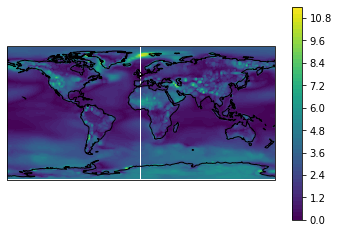

In [17]:
tas = abs_error['tas','DJF','ECE','glob'].variables['tas'][0, :, :]
lats = abs_error['tas','DJF','ECE','glob'].variables['lat'][:]
lons = abs_error['tas','DJF','ECE','glob'].variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, tas, 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)
plt.show()

In [64]:
#Read precalculated cmip6 field mean of errors from csv files
collect = np.empty([len(eval_models),len(obs),len(regions),len(seasons)])*np.nan
i=0
for eval_model in eval_models:
    df = pd.read_csv(eval_path+eval_model+'.csv', delimiter=' ')
    values = df['AbsMeanError'] #you can also use df['column_name']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading',eval_model,var)
            pass
        else:
            j+=1
            print('skipping',eval_model,var)
            continue
        for region in regions:
            l=0
            if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                continue
            for seas in seasons:
                collect[i,j,k,l]=values[r]
                l+=1
                r+=1
            k+=1
        j+=1
    i+=1
ensmean=np.nanmean(collect,axis=0)

reading BCC siconc
reading BCC tas
reading BCC clt
reading BCC pr
reading BCC rlut
reading BCC uas
reading BCC vas
reading BCC ua
reading BCC zg
reading CAMS siconc
reading CAMS tas
reading CAMS clt
reading CAMS pr
reading CAMS rlut
reading CAMS uas
reading CAMS vas
reading CAMS ua
reading CAMS zg
reading ECE siconc
reading ECE tas
reading ECE clt
reading ECE pr
reading ECE rlut
reading ECE uas
reading ECE vas
reading ECE ua
reading ECE zg
reading HadGEM3MM siconc
reading HadGEM3MM tas
reading HadGEM3MM clt
reading HadGEM3MM pr
reading HadGEM3MM rlut
reading HadGEM3MM uas
reading HadGEM3MM vas
reading HadGEM3MM ua
reading HadGEM3MM zg
reading INM5 siconc
reading INM5 tas
reading INM5 clt
reading INM5 pr
reading INM5 rlut
reading INM5 uas
reading INM5 vas
reading INM5 ua
reading INM5 zg
skipping IITM siconc
reading IITM tas
reading IITM clt
reading IITM pr
reading IITM rlut
reading IITM uas
reading IITM vas
skipping IITM ua
skipping IITM zg
reading MRI siconc
reading MRI tas
reading MRI

/tmp/ipykernel_6041/2810231248.py:30: RuntimeWarning: Mean of empty slice
  ensmean=np.nanmean(collect,axis=0)


In [65]:
#Place sums of error into easier to inspect dictionary
eval_error_mean = OrderedDict()
j=0
for var in obs:
    k=0
    for region in regions:
        l=0
        if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
            continue
        for seas in seasons:
            eval_error_mean[var,region,seas]=ensmean[j,k,l]
            l+=1
        k+=1
    j+=1

In [66]:
#calculate ratio of current model error to evaluation model error
error_fraction = OrderedDict()
sum=0
for model in models:
    for var in models[model]:
        for region in regions:
            if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                continue
            for seas in seasons:
                error_fraction[var,seas,model,region] = mean_error[var,seas,model,region] / eval_error_mean[var,region,seas]


In [70]:
#Write ratio of field mean of errors into csv files and sum up error fractions for cmpi score
#TODO beautification: find way to access error_fraction[var,seas,model,region].var.values[0]
sum=0
iter=0
for model in models:
    with open(out_path+model+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                    continue
                for seas in seasons:
                    if (var == 'tas'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].tas.values[0]])
                        sum+=error_fraction[var,seas,model,region].tas.values[0]
                    if (var == 'uas'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].uas.values[0]])
                        sum+=error_fraction[var,seas,model,region].uas.values[0]
                    if (var == 'vas'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].vas.values[0]])
                        sum+=error_fraction[var,seas,model,region].vas.values[0]
                    if (var == 'ua'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].ua.values[0][0]])
                        sum+=error_fraction[var,seas,model,region].ua.values[0][0]
                    if (var == 'zg'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].zg.values[0][0]])
                        sum+=error_fraction[var,seas,model,region].zg.values[0][0]
                    if (var == 'pr'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].pr.values[0]])
                        sum+=error_fraction[var,seas,model,region].pr.values[0]
                    if (var == 'rlut'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].rlut.values[0]])
                        sum+=error_fraction[var,seas,model,region].rlut.values[0]
                    if (var == 'clt'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].clt.values[0]])
                        sum+=error_fraction[var,seas,model,region].clt.values[0]
                    if (var == 'siconc'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].siconc.values[0]])
                        sum+=error_fraction[var,seas,model,region].siconc.values[0]
                    iter+=1
        cmpi=sum/iter
        writer.writerow(['CMPI',cmpi])